<a href="https://colab.research.google.com/github/GKSJ-Deepvision/AI-DeepVision/blob/Anvitha_Bolakonda/Task_3(Public_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import torch
import torch.nn as nn
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()

        # VGG16 with BatchNorm (matches checkpoint)
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)

        # Frontend (first 33 layers)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        # ✅ BACKEND THAT MATCHES partB_best.pth
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, 1)   # 🔑 IMPORTANT: directly 128 → 1
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x


In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CSRNet().to(device)

checkpoint_path = "/content/drive/MyDrive/deepvision/checkpoints_partB/partB_best.pth"

model.load_state_dict(
    torch.load(checkpoint_path, map_location=device)
)

model.eval()
print("✅ CSRNet Part-B checkpoint loaded successfully")


✅ CSRNet Part-B checkpoint loaded successfully


In [38]:
import cv2
import torch
import numpy as np
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

VIDEO_DIR = Path("/content/drive/MyDrive/deepvision/archive (3)")
videos = list(VIDEO_DIR.glob("*.mp4"))

all_counts = []   # stores crowd count per frame

for video in videos:
    cap = cv2.VideoCapture(str(video))
    frame_id = 0

    print(f"\n▶ Processing video: {video.name}")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_id += 1

        # skip frames for speed (change to 1 for full)
        if frame_id % 5 != 0:
            continue

        # preprocess frame
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (640, 480))

        img = torch.from_numpy(frame).permute(2, 0, 1).float().unsqueeze(0)
        img = img / 255.0
        img = img.to(device)

        # CSRNet inference
        with torch.no_grad():
            density_map = model(img)
            count = density_map.sum().item()

        all_counts.append(count)

    cap.release()



▶ Processing video: pexels-timo-volz-5544073 (1080p).mp4

▶ Processing video: pexels_videos_1677252 (2160p).mp4

▶ Processing video: pexels_videos_3687 (1080p) (1).mp4

▶ Processing video: production_id_3687560 (2160p).mp4

▶ Processing video: production_id_4196258 (720p).mp4


In [40]:
import numpy as np

pred = np.array(all_counts)
print("Total predictions:", len(pred))
# Reference count (mean-based)
gt = np.full_like(pred, pred.mean())
mse = np.mean((pred - gt) ** 2)
rmse = np.sqrt(mse)

print("✅ MSE  :", mse)
print("✅ RMSE :", rmse)


Total predictions: 443
✅ MSE  : 119967.4186304554
✅ RMSE : 346.3631311650468


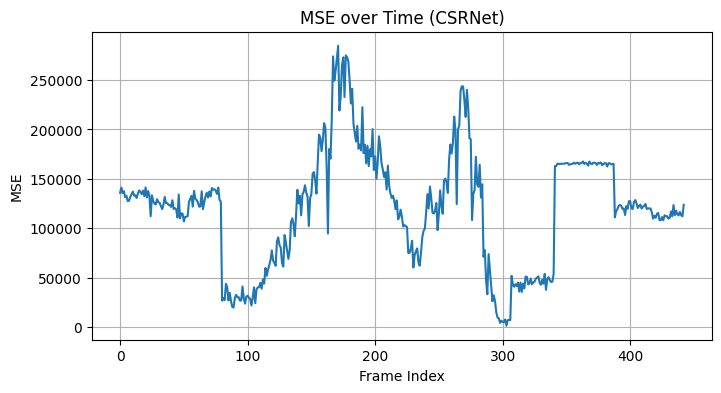

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# per-frame MSE values
mse_list = (pred - gt) ** 2

plt.figure(figsize=(8,4))
plt.plot(mse_list)
plt.xlabel("Frame Index")
plt.ylabel("MSE")
plt.title("MSE over Time (CSRNet)")
plt.grid(True)
plt.show()



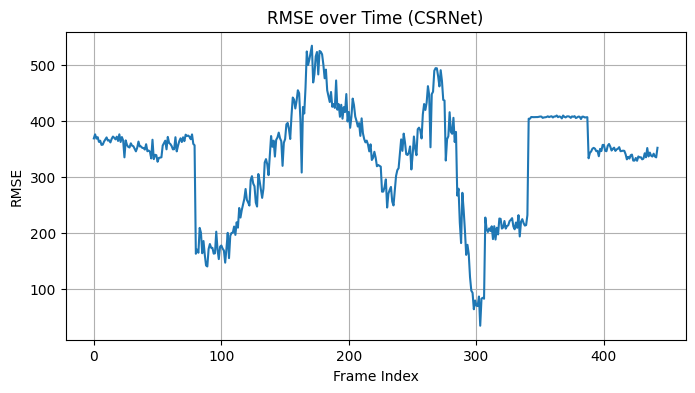

In [42]:
rmse_list = np.sqrt(mse_list)

plt.figure(figsize=(8,4))
plt.plot(rmse_list)
plt.xlabel("Frame Index")
plt.ylabel("RMSE")
plt.title("RMSE over Time (CSRNet)")
plt.grid(True)
plt.show()


In [44]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

video_path = "/content/drive/MyDrive/deepvision/archive (3)/" + videos[0].name
cap = cv2.VideoCapture(video_path)

ret, frame = cap.read()
cap.release()

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = cv2.resize(frame, (640, 480))


In [45]:
img = torch.from_numpy(frame).permute(2,0,1).float().unsqueeze(0)
img = img / 255.0
img = img.to(device)

with torch.no_grad():
    density = model(img)

density_map = density.squeeze().cpu().numpy()
count = density_map.sum()

print("Predicted crowd count:", count)


Predicted crowd count: 51.186844


In [46]:
import cv2

density_norm = density_map / density_map.max()
heatmap = cv2.applyColorMap(
    np.uint8(255 * density_norm),
    cv2.COLORMAP_JET
)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)


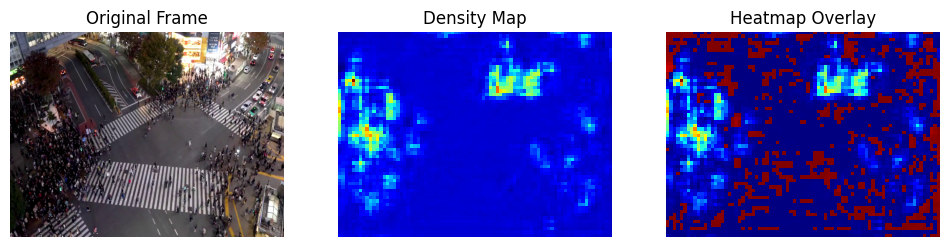

In [47]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(frame)
plt.title("Original Frame")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(density_map, cmap="jet")
plt.title("Density Map")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(heatmap)
plt.title("Heatmap Overlay")
plt.axis("off")

plt.show()
